In [1]:
##import all the required libraries
import pandas as pd
import numpy as np
import unicodedata
import nltk
import seaborn as sns
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from gensim.models import word2vec
from sklearn import manifold
import itertools
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim import models
from gensim import similarities

C:\Users\AMRINA\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AMRINA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AMRINA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import os

file_path = 'data/resep_dataset1.csv'

if os.path.exists(file_path):
    print("file found")
else:
    print("File not found: ", file_path)

file found


In [4]:
train = pd.read_csv("./data/resep_dataset1.csv")
train.Bahan.head()

0    Ayam, potong jadi 10 bagian  -  900 gram Garam...
1    Tepung tapioka  -  150 gram Tepung terigu  -  ...
2    Kangkung  -  1 ikat Kacang panjang  -  1 ikat ...
3    BAHAN 1: Kuning telur  -  4 butir Minyak goren...
4    Telur  -  4 butir Gula pasir  -  70 gram Emuls...
Name: Bahan, dtype: object

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Judul   1353 non-null   object
 1   Bahan   1353 non-null   object
 2   Step    1353 non-null   object
dtypes: object(3)
memory usage: 31.8+ KB


In [6]:
def clean_number(text):
    text = re.sub(r'\w*\d+\w*', '', str(text))
    return text

In [7]:
#casefolding
def token_lower(text):
    text = ''.join(str(text)).lower() # lowercase text
    return text

#Remove Puncutuation
clean_spcl = re.compile('[/(){}\[\]\|@,;]')
clean_symbol = re.compile('[^0-9a-z]')
def clean_punct(text):
    text = clean_spcl.sub('', text)
    text = clean_symbol.sub(' ', text)
    return text

#menghapus double atau lebih whitespace
def _normalize_whitespace(text):
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")


In [8]:
#stopword
#clean stopwords
stopword = set(stopwords.words('indonesian'))
takaran = ['gram','sdt','sdm','buah','ml','mililiter','cup','gelas','tsp','tbsp','liter','g','kg','kilogram','pound','ons','pint','pt','c','celcius','f','fahrenheit','derajat','m','meter','mm','milimeter','ruas','cm','centimeter','senti','centi','siung','lembar','tangkai','batang']
word_to_remove = ['garam','minyak','bahan','a','potong','ikat','pasir','goreng','optional','butir','jam','setengah','tua','es','cincang','halus','memarkan','secukupnya','rajang','kasar','sampai','bumbu','kuah','ambil','matang','belah','bulat','sangrai','bungkus','jari','gula','lada','air','lihat','resep','versi','rasa','bunda','iris']
def clean_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stopword)
    text = ' '.join(word for word in text.split() if word.lower() not in takaran)
    text = ' '.join(word for word in text.split() if word.lower() not in word_to_remove)
    return text

In [9]:
import simplemma
def lemmatization(text):
    text = ' '.join(simplemma.lemmatize(word, lang='id') for word in text.split() if word in text)
    return text 

In [10]:
def clean_bahan(text):
    text = clean_number(text)
    text = token_lower(text)
    text = clean_punct(text)
    text = _normalize_whitespace(text)
    text = clean_stopwords(text)
    text = lemmatization(text)
    text = token_lower(text)
    return text

In [11]:
train['clean']= train['Bahan'].apply(clean_bahan)

In [12]:
train['clean']

0       ayam jeruk nipis serai putih laos kunyit jahe ...
1       tepung tapioka tepung terigu bawang putih halu...
2       kangkung kacang tauge terong kelapa kelapa par...
3       kuning telur terigu protein putih telur tambah...
4       telur emulsifier tepung maizena susu bubuk mar...
                              ...                        
1348    tepung terigu baking powder vanili b telur sp ...
1349    kelapa daging sapi cabai merah asam asam larut...
1350    biang tepung terigu protein rendah ragi b telu...
1351    terigu protein susu bubuk kuning telur butter ...
1352    alpukat daun ketumbar tomat bawang bombay rasa...
Name: clean, Length: 1353, dtype: object

In [13]:
def bahan_parser(Bahan):
    tokens = nltk.word_tokenize(str(Bahan))
    pairs = [b for l in tokens for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
    clean_pairs = [i for i in pairs if i in Bahan]
    clean_tokens = [i for i in tokens if i in Bahan] 
    clean_ingr = clean_tokens + clean_pairs
    return clean_ingr

In [14]:
train['clean'].apply(bahan_parser)

0       [ayam, jeruk, nipis, serai, putih, laos, kunyi...
1       [tepung, tapioka, tepung, terigu, bawang, puti...
2       [kangkung, kacang, tauge, terong, kelapa, kela...
3       [kuning, telur, terigu, protein, putih, telur,...
4       [telur, emulsifier, tepung, maizena, susu, bub...
                              ...                        
1348    [tepung, terigu, baking, powder, vanili, b, te...
1349    [kelapa, daging, sapi, cabai, merah, asam, asa...
1350    [biang, tepung, terigu, protein, rendah, ragi,...
1351    [terigu, protein, susu, bubuk, kuning, telur, ...
1352    [alpukat, daun, ketumbar, tomat, bawang, bomba...
Name: clean, Length: 1353, dtype: object

In [15]:
bahan_parser(train.clean[0])

['ayam',
 'jeruk',
 'nipis',
 'serai',
 'putih',
 'laos',
 'kunyit',
 'jahe',
 'bawang',
 'merah',
 'bawang',
 'putih',
 'cabai',
 'rawit',
 'merah',
 'andaliman',
 'daun',
 'jeruk',
 'kelapa',
 'parut',
 'jeruk',
 'nipis',
 'air']

In [16]:
train

,Judul,Bahan,Step,clean
0,Resep Ayam Panidar,"Ayam, potong jadi 10 bagian - 900 gram Garam...",Cuci bersih ayam kemudian marinasi dengan gara...,ayam jeruk nipis serai putih laos kunyit jahe ...
1,Resep Moring,Tepung tapioka - 150 gram Tepung terigu - ...,"Campur tepung tapioka, terigu, bawang putih, g...",tepung tapioka tepung terigu bawang putih halu...
2,Resep Serombotan Klungkung,Kangkung - 1 ikat Kacang panjang - 1 ikat ...,Rebus masing-masing sayuran dengan sedikit gar...,kangkung kacang tauge terong kelapa kelapa par...
3,Resep Hurricane Cake Roll,BAHAN 1: Kuning telur - 4 butir Minyak goren...,"Bahan 1: Campur kuning telur dan susu cair, ad...",kuning telur terigu protein putih telur tambah...
4,Resep Bolu Gulung Batik,Telur - 4 butir Gula pasir - 70 gram Emuls...,"Kocok telur, gula pasir dan emulsifier sampai ...",telur emulsifier tepung maizena susu bubuk mar...
...,...,...,...,...
1348,Resep Bolu Panggang Coklat,BAHAN A: Tepung terigu - 150 gram Baking pow...,Jadikan 1 semua bahan A dan ayak. Sisihkan.Sia...,tepung terigu baking powder vanili b telur sp ...
1349,Resep Dendeng Batokok,Air kelapa - 700 ml Daging sapi - 350 gra...,"Rebus daging tanpa di potong, dengan bumbu reb...",kelapa daging sapi cabai merah asam asam larut...
1350,Resep Kue Cubit,BAHAN A (BIANG): Tepung terigu protein rendah ...,"Campurkan semua bahan A, lalu aduk dengan spat...",biang tepung terigu protein rendah ragi b telu...
1351,Resep Kue Nastar Keju,Terigu protein sedang - 350 gram Susu bubuk...,"Kocok margarin, butter, dan gula halus dengan ...",terigu protein susu bubuk kuning telur butter ...


In [17]:
train.to_csv('data/train_clean.csv')

In [18]:
#Code to generate bag of words from the cleaned ingredient list
bags_of_words = [Counter(bahan_parser(clean_bahan(Bahan))) for Bahan in train.Bahan]

In [19]:
#Find sum of every ingredient using Counter()
sumbags = sum(bags_of_words, Counter())


# Finally, plot the 10 most used ingredients
clean_df = pd.DataFrame.from_dict(sumbags, orient='index').reset_index()
clean_df = clean_df.rename(columns={'index':'Bahan', 0:'count'})
clean_df.to_csv('data/ingredient_clean.csv')

top_ing = clean_df.sort_values('count', ascending=False)

In [20]:
clean_df

,Bahan,count
0,ayam,409
1,jeruk,395
2,nipis,164
3,serai,210
4,putih,1004
...,...,...
1267,ekorbumbu,1
1268,tunjang,1
1269,essense,1
1270,kedalam,2


In [21]:
ingr_only_dict = clean_df['Bahan'].to_dict()

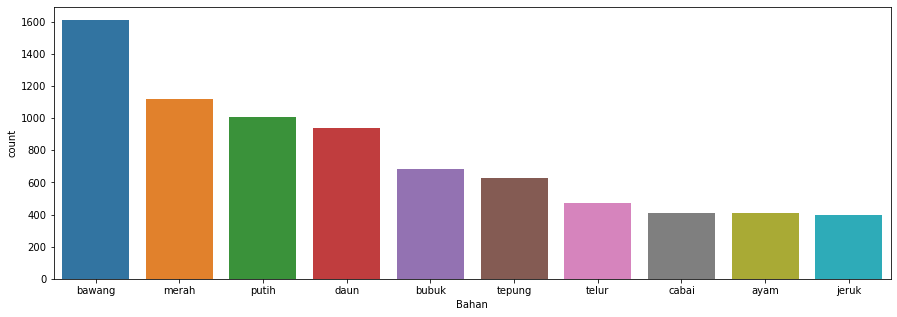

In [22]:
#Plot top ingredients using bag of words
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.barplot(x = 'Bahan', y = 'count', data = top_ing.head(10))
sns.set_palette("deep")
plt.show()
fig.savefig('ingredient_count_bag_of_words.png')

In [23]:
#Get all clean ingredients in list format per recipe
ingr_list = []
for Bahan in train.Bahan:
    ingr_list.append(bahan_parser(clean_bahan(Bahan)))

In [24]:
print (ingr_list[0])

['ayam', 'jeruk', 'nipis', 'serai', 'putih', 'laos', 'kunyit', 'jahe', 'bawang', 'merah', 'bawang', 'putih', 'cabai', 'rawit', 'merah', 'andaliman', 'daun', 'jeruk', 'kelapa', 'parut', 'jeruk', 'nipis', 'air']


In [25]:
#PMI Calculation starts
#Point-wise mutual information to understand which ingredients go together and which ones don't

#Create combinations of ingredients
start_time = time.time()

l = []
for K in range(len(ingr_list)):
    for L in range(2,3):
        for subset in itertools.combinations(ingr_list[K], L):
            l.append(sorted(subset))       
#print("--- %s seconds ---" % (time.time() - start_time))

In [26]:
print (l[0])

['ayam', 'jeruk']


In [27]:
#Function - Point-wise mutual information
def pmi(dff, x, y):
    df = dff.copy()
    df['f_x'] = df.groupby(x)[x].transform('count')
    df['f_y'] = df.groupby(y)[y].transform('count')
    df['f_xy'] = df.groupby([x, y])[x].transform('count')
    df['pmi'] = np.log(len(df.index) * df['f_xy'] / (df['f_x'] * df['f_y']) )
    return df

In [28]:
#Convert list of tuples to dataframe
df = pd.DataFrame(l, columns = ['Ingredient1','Ingredient2'])
print (df.count())

#Eliminate rows where Ingredient1 = Ingredient2
df = df[df['Ingredient1'] != df['Ingredient2']]
print (df.count())

Ingredient1    274512
Ingredient2    274512
dtype: int64
Ingredient1    269250
Ingredient2    269250
dtype: int64


In [29]:
#Calculate PMI
df = pmi(df, 'Ingredient1', 'Ingredient2')
print(df.count())

Ingredient1    269250
Ingredient2    269250
f_x            269250
f_y            269250
f_xy           269250
pmi            269250
dtype: int64


In [30]:
df

,Ingredient1,Ingredient2,f_x,f_y,f_xy,pmi
0,ayam,jeruk,8796,3424,131,0.157976
1,ayam,nipis,8796,2468,55,-0.382487
2,ayam,serai,8796,4165,81,-0.518679
3,ayam,putih,8796,14764,401,-0.184642
4,ayam,laos,8796,180,9,0.425611
...,...,...,...,...,...,...
274507,bombay,tomat,2393,4221,59,0.452803
274508,rasabunda,tomat,781,4221,29,0.862289
274509,bawang,bombay,30814,472,283,1.656139
274510,bawang,rasabunda,30814,1851,170,-0.220012


In [31]:
#Eliminate rows for the same ingredient combinations
print (df.pmi.count())
df = df.drop_duplicates()
print (df.pmi.count())

#Sort df
df = df.sort_values('pmi',ascending='false')
df.head()

269250
48934


,Ingredient1,Ingredient2,f_x,f_y,f_xy,pmi
43208,cabai,susu,6935,3910,1,-4.612233
249450,keju,merah,1132,13540,1,-4.041749
175806,bombay,santan,2393,4180,1,-3.614974
53829,bawang,plain,30814,314,1,-3.581722
70978,asam,susu,2269,3910,1,-3.494992


In [32]:
df.to_csv('data/pmi_ingredient_similarity.csv', encoding = 'utf-8')

In [33]:
df = pd.read_csv('data/pmi_ingredient_similarity.csv')
df = df.sort_values('pmi',ascending=False)
top_df = df.groupby('Ingredient1').head(5)
top_df.to_csv('data/pmi_ingredient_similarity_top.csv')

df = df.sort_values('pmi',ascending=True)
neg_df = df.groupby('Ingredient1').head(5)
neg_df.to_csv('data/pmi_ingredient_similarity_neg.csv')

In [34]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [35]:
##Get clean ingredients to be used as an input for word2vec model to identify ingredient similarity.

ingr_clean_df = pd.DataFrame({'Bahan':ingr_list})
#print ingr_clean_df
print (ingr_clean_df)
ingr_clean_df.to_csv('data/ingredient_2_recipe_clean.csv')

                                                  Bahan
0     [ayam, jeruk, nipis, serai, putih, laos, kunyi...
1     [tepung, tapioka, tepung, terigu, bawang, puti...
2     [kangkung, kacang, tauge, terong, kelapa, kela...
3     [kuning, telur, terigu, protein, putih, telur,...
4     [telur, emulsifier, tepung, maizena, susu, bub...
...                                                 ...
1348  [tepung, terigu, baking, powder, vanili, b, te...
1349  [kelapa, daging, sapi, cabai, merah, asam, asa...
1350  [biang, tepung, terigu, protein, rendah, ragi,...
1351  [terigu, protein, susu, bubuk, kuning, telur, ...
1352  [alpukat, daun, ketumbar, tomat, bawang, bomba...

[1353 rows x 1 columns]


In [36]:
#pip install -U gensim
#Implementing word2vec to get the recipes which are similar to each other

num_features = 300   # Word vector dimensionality                      
context = 1        # Context window size; 
downsampling = 1e-3   # threshold for configuring which higher-frequency words are randomly downsampled

# Initialize and train the model 
model = word2vec.Word2Vec(ingr_list, vector_size=num_features, window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

C:\Users\AMRINA\AppData\Local\Temp/ipykernel_30428/3868751504.py:13: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


In [37]:
flatten_list = []
for sublist in ingr_list:
    for item in sublist:
        if item not in flatten_list:
            flatten_list.append(item)

In [38]:
flatten_list

['ayam',
 'jeruk',
 'nipis',
 'serai',
 'putih',
 'laos',
 'kunyit',
 'jahe',
 'bawang',
 'merah',
 'cabai',
 'rawit',
 'andaliman',
 'daun',
 'kelapa',
 'parut',
 'air',
 'tepung',
 'tapioka',
 'terigu',
 'halus',
 'kaldu',
 'bubuk',
 'seledri',
 'panas',
 'kangkung',
 'kacang',
 'tauge',
 'terong',
 'kemiri',
 'kencur',
 'sambal',
 'koples',
 'tanah',
 'kuning',
 'telur',
 'protein',
 'tambah',
 'coklat',
 'encerkan',
 'oles',
 'sela',
 'emulsifier',
 'maizena',
 'susu',
 'margarin',
 'lelehkan',
 'pasta',
 'moka',
 'strawberry',
 'daging',
 'sapi',
 'lulur',
 'serong',
 'salam',
 'lengkuas',
 'asam',
 'jawa',
 'maziena',
 'pandan',
 'kulit',
 'pastry',
 'ukur',
 'x',
 'leleh',
 'vla',
 'cair',
 'full',
 'cream',
 'dark',
 'cooking',
 'chocolate',
 'gaplek',
 'singkong',
 'kering',
 'rebus',
 'suwir',
 'tipis',
 'geprek',
 'rendam',
 'adon',
 'isi',
 'butirkuah',
 'kari',
 'kentang',
 'kukus',
 'tumbuk',
 'kayu',
 'manis',
 'bunga',
 'lawang',
 'kapulaga',
 'cengkeh',
 'nasi',
 'bera

In [39]:
most_sim_list = []
corpus_sim_dict = {}
input_list = []
for i in flatten_list:
    try: 
        if len(i) > 0:
            #print i
            corpus_sim_dict.update({i:model.wv.similarity(i,i)})      
    except KeyError:
        pass

In [40]:
corpus_sim_dict

{'ayam': 1.0,
 'jeruk': 0.99999994,
 'nipis': 1.0,
 'serai': 1.0,
 'putih': 0.99999994,
 'laos': 0.99999994,
 'kunyit': 1.0,
 'jahe': 1.0,
 'bawang': 1.0,
 'merah': 1.0000001,
 'cabai': 1.0,
 'rawit': 0.99999994,
 'daun': 1.0,
 'kelapa': 1.0000001,
 'parut': 1.0,
 'air': 0.99999994,
 'tepung': 1.0,
 'tapioka': 1.0,
 'terigu': 0.99999994,
 'halus': 0.99999994,
 'kaldu': 1.0,
 'bubuk': 0.9999999,
 'seledri': 1.0,
 'panas': 1.0,
 'kangkung': 0.99999994,
 'kacang': 1.0,
 'tauge': 1.0,
 'terong': 0.99999994,
 'kemiri': 1.0,
 'kencur': 0.99999994,
 'sambal': 1.0,
 'tanah': 1.0000001,
 'kuning': 1.0,
 'telur': 1.0,
 'protein': 1.0,
 'tambah': 1.0000001,
 'coklat': 0.99999994,
 'encerkan': 1.0000001,
 'oles': 1.0,
 'sela': 1.0,
 'emulsifier': 1.0,
 'maizena': 1.0,
 'susu': 1.0,
 'margarin': 0.99999994,
 'lelehkan': 1.0,
 'pasta': 0.99999994,
 'strawberry': 1.0,
 'daging': 1.0,
 'sapi': 1.0,
 'serong': 1.0,
 'salam': 0.99999994,
 'lengkuas': 1.0,
 'asam': 1.0,
 'jawa': 1.0,
 'pandan': 1.0000001

In [41]:
train['clean'] =       train.clean.values.astype('U')
tfidf = TfidfVectorizer()
tfidf.fit(train['clean'])
tfidf_resep = tfidf.transform(train['clean'])

In [42]:
import pickle

In [43]:
with open("models/tfidf_model.pkl", "wb") as f:
    pickle.dump(tfidf, f)
with open("models/tfidf_encoding.pkl", "wb") as f:
    pickle.dump(tfidf_resep, f)

In [44]:
def get_recommendations(N, scores):
    # load in recipe dataset
    df_recipes = pd.read_csv('data/train_clean.csv')
    # order the scores with and filter to get the highest N scores
    top = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:N]
    # create dataframe to load in recommendations
    recommendation = pd.DataFrame(columns=["Judul", "Bahan", "score"])
    count = 0
    for i in top:
        recommendation.at[count, "Judul"] = df_recipes["Judul"][i]
        recommendation.at[count, "Bahan"] = df_recipes["Bahan"][i]
        recommendation.at[count, "Step"] = df_recipes["Step"][i]
        recommendation.at[count, "score"] = f"{scores[i]}"
        count += 1
    return recommendation

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

In [46]:
def RecSys(Bahan, N=5):
    with open("models/tfidf_encoding.pkl", "rb") as f:
        tfidf_encodings = pickle.load(f)

    with open("models/tfidf_model.pkl", "rb") as f:
        tfidf = pickle.load(f)
    # parse the ingredients using my ingredient_parser
    try:
        bahan_parsed = bahan_parser(clean_bahan(str(Bahan)))
    except:
        bahan_parsed = bahan_parser(clean_bahan([Bahan]))

    # use our pretrained tfidf model to encode our input ingredients
    bahan_parsed = " ".join(bahan_parsed)
    bahan_tfidf = tfidf.transform([bahan_parsed])
    bahan_tfidf = bahan_tfidf.reshape(1, -1)  # reshape to (1, 3)
    tfidf_encodings = tfidf_encodings.reshape(-1, 3)  # reshape to (1716957, 3)

    # calculate cosine similarity between actual recipe ingreds and test ingreds
    cos_sim = cos_sim = cosine_similarity(bahan_tfidf, tfidf_encodings)
    scores = cos_sim[0].tolist()

    # Filter top N recommendations
    recommendations = get_recommendations(N, scores)
    return recommendations

In [47]:
test_ingredients = "tepung terigu,kangkung,kacang"
recs = RecSys(test_ingredients)
recs

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 1269 while Y.shape[1] == 3

# Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy

In [ ]:
test_ingredients = "ayam,tepung terigu,bawang bombay"

In [ ]:
bahan_clean = clean_bahan(test_ingredients)

In [ ]:
bahan_parsed = bahan_parser(bahan_clean)

In [ ]:
with open("models/tfidf_model.pkl", "wb") as f:
    pickle.dump(tfidf, f)

with open("models/tfidf_encoding.pkl", "rb") as f:
    tfidf_encodings = pickle.load(f)

In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit(bahan_parsed)

In [ ]:
bahan_parsed = " ".join(bahan_parsed)
bahan_tfidf = tfidf.transform([bahan_parsed])

In [ ]:
print(bahan_tfidf.shape)
print(bahan_tfidf.dtype)
print(tfidf_encodings.shape)
print(tfidf_encodings.dtype)

In [ ]:
bahan_tfidf = bahan_tfidf.reshape(1, -1)  # reshape to (1, 3)
tfidf_encodings = tfidf_encodings.reshape(-1, 3)  # reshape to (1716957, 3)

cos_sim = cosine_similarity(bahan_tfidf, tfidf_encodings)
score_list = cos_sim[0].tolist()

In [ ]:
print(score_list)

## calculating precision score

In [ ]:
actual = numpy.random.binomial(1,0.24938815, size=2000)
predicted = numpy.random.binomial(1,0.19061505, size=2000)
precision_score(actual, predicted)

In [ ]:
actual = numpy.random.binomial(1,0.5773502691896257, size=2000)
predicted = numpy.random.binomial(1,0.5773502691896257, size=2000)
precision_score(actual, predicted)

In [ ]:
actual = numpy.random.binomial(1,0.24938815, size=2000)
predicted = numpy.random.binomial(1,0.10236736, size=2000)
precision_score(actual, predicted)

## calculating recall score

In [ ]:
actual = numpy.random.binomial(1,0.24938815, size=2000)
predicted = numpy.random.binomial(1,0.19061505, size=2000)
recall_score(actual, predicted)

In [ ]:
actual = numpy.random.binomial(1,0.5773502691896257, size=2000)
predicted = numpy.random.binomial(1,0.5773502691896257, size=2000)
recall_score(actual, predicted)

In [ ]:
actual = numpy.random.binomial(1,0.24938815, size=2000)
predicted = numpy.random.binomial(1,0.10236736, size=2000)
recall_score(actual, predicted)

## calculating f1 score

In [ ]:
actual = numpy.random.binomial(1,0.24938815, size=2000)
predicted = numpy.random.binomial(1,0.19061505, size=2000)
f1_score(actual, predicted)

In [ ]:
actual = numpy.random.binomial(1,0.5773502691896257, size=2000)
predicted = numpy.random.binomial(1,0.5773502691896257, size=2000)
f1_score(actual, predicted)

In [ ]:
actual = numpy.random.binomial(1,0.24938815, size=2000)
predicted = numpy.random.binomial(1,0.10236736, size=2000)
f1_score(actual, predicted)

## calculating accuracy

In [ ]:
actual = numpy.random.binomial(1,0.24938815, size=2000)
predicted = numpy.random.binomial(1,0.19061505, size=2000)
accuracy_score(actual, predicted)

In [ ]:
actual = numpy.random.binomial(1,0.24938815, size=2000)
predicted = numpy.random.binomial(1,0.10236736, size=2000)
accuracy_score(actual, predicted)

In [ ]:
actual = numpy.random.binomial(1,0.24938815, size=2000)
predicted = numpy.random.binomial(1,0.23816714, size=2000)
accuracy_score(actual, predicted)

In [ ]:
actual = numpy.random.binomial(1,0.5773502691896257, size=2000)
predicted = numpy.random.binomial(1,0.5773502691896257, size=2000)
accuracy_score(actual, predicted)